In [2]:
# -*- coding: utf-8 -*-
from __future__ import division
import sys
sys.path.append('C:\\Users\\51951\\PycharmProjects\\joinquantNew\\gpLearn')
import pandas as pd
import numpy as np
import time  
import datetime
from matplotlib import cm, pyplot as plt
from sklearn.feature_selection import VarianceThreshold
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2
from factors201 import *
import inspect
from jqdatasdk import *
from configDB import *
import os
auth(JOINQUANT_USER, JOINQUANT_PW)
from scipy import stats
import math
import warnings
warnings.filterwarnings("ignore")

提示：当前环境pandas版本为0.25，get_price与get_fundamentals_continuously接口panel参数将固定为False
注意：0.25以上版本pandas不支持panel，如使用该数据结构和相关函数请注意修改
auth success 


In [3]:
colums_lst = ["alpha046", "alpha049", "alpha052", "alpha071", "alpha082", "alpha093", "alpha096", "alpha112",
                  "alpha128", "alpha129", "alpha133"]
colums_lst.extend(['date_time', 'close', 'future_ret'])
feature_lst = ["alpha046", "alpha049", "alpha052", "alpha071", "alpha082", "alpha093", "alpha096", "alpha112",
                  "alpha128", "alpha129", "alpha133"]

In [4]:
sdate = '2014-01-01'
listday_info = get_all_securities(types=['stock']).query("start_date<'{date}'".format(date=sdate))
stock_lst = listday_info.index.tolist()

In [5]:
len(stock_lst)

2527

In [6]:
resualt_path = 'c:/e/data/factor/'
indicator_ori = []
for code in stock_lst:
    ret = pd.read_csv(resualt_path + 'indicator_%s.csv' % code[:6], encoding='gbk', index_col=0)[colums_lst]
    ret['symbol'] = code
    indicator_ori.append(ret)
indicator_ori = pd.concat(indicator_ori)

In [7]:
len(indicator_ori), len(indicator_ori.dropna())

(3804370, 3737597)

In [8]:
indicator_df_day = indicator_ori[indicator_ori['date_time'] == '2020-10-20'].drop(['date_time', 'close', 'future_ret'], axis=1)\
.set_index(['symbol'])

In [9]:
indicator_df_day

,alpha046,alpha049,alpha052,alpha071,alpha082,alpha093,alpha096,alpha112,alpha128,alpha129,alpha133
symbol,,,,,,,,,,,
000001.XSHE,-0.939798,0.726695,208.116883,11.426983,-21.582340,-0.042848,85.266611,69.142857,76.785162,-0.035180,40.0
000002.XSHE,-1.014738,0.371154,109.014904,-2.391665,-83.403308,-0.090183,18.591039,-20.129870,41.486475,-0.065865,-75.0
000004.XSHE,-0.955131,0.766110,126.412389,7.859022,-21.485149,-0.156094,68.901641,35.978836,71.337548,-0.096370,85.0
000005.XSHE,-0.999380,0.490196,70.170455,-1.435115,-82.500000,-0.170727,65.190365,19.047619,48.564100,-0.063798,-50.0
000006.XSHE,-1.023126,0.378641,109.148551,-1.185876,-87.699331,-0.193782,11.294766,-9.012876,54.468377,-0.187073,65.0
...,...,...,...,...,...,...,...,...,...,...,...
603333.XSHG,-0.999000,0.512821,117.993631,0.541863,-82.217532,-0.097686,22.222222,5.376344,43.542575,-0.060531,50.0
603366.XSHG,-0.994383,0.362637,86.687307,-1.552941,-88.135965,-0.109667,24.526749,-5.747126,36.842550,-0.087558,-45.0
603399.XSHG,-1.011463,0.424837,59.112150,-7.111111,-51.219512,-0.262960,60.670433,-8.695652,36.393993,-0.120010,-55.0


## 去极值

In [10]:
def de_extreme(indicator_df_day, feature_lst):
    indicator_df_day_temp = copy.deepcopy(indicator_df_day)
    MAD = abs(indicator_df_day_temp - indicator_df_day_temp.median())
    MAX=indicator_df_day_temp.median() + 3 * 1.4826 * MAD.median()
    MIN=indicator_df_day_temp.median() - 3 * 1.4826 * MAD.median()
    for alpha in feature_lst:
        ori = copy.deepcopy(indicator_df_day_temp[alpha])
        series = copy.deepcopy(ori)
        series[series>MAX[alpha]] = MAX[alpha]
        series[series<MIN[alpha]] = MIN[alpha]
        indicator_df_day_temp[alpha] = copy.deepcopy(series)
        df = pd.DataFrame({'ori': ori, 'de_extreme': indicator_df_day_temp[alpha]})\
        .reset_index(drop=True)
#         plt.subplots(20, 10)
        df.loc[:, ['ori', 'de_extreme']].plot()
        plt.legend()
        plt.title('%s ori_max:%s deal_max:%s ori_min:%s deal_min:%s' %(
            alpha, np.around(ori.max(), 2), np.around(series.max(), 2), np.around(ori.min(), 2), 
                  np.around(series.min(), 2)))
        plt.show()
    return(indicator_df_day_temp)

def de_extreme_noplot(indicator_df_day, feature_lst):
    indicator_df_day_temp = copy.deepcopy(indicator_df_day)
    MAD = abs(indicator_df_day_temp - indicator_df_day_temp.median())
    MAX=indicator_df_day_temp.median() + 3 * 1.4826 * MAD.median()
    MIN=indicator_df_day_temp.median() - 3 * 1.4826 * MAD.median()
    for alpha in feature_lst:
        ori = copy.deepcopy(indicator_df_day_temp[alpha])
        series = copy.deepcopy(ori)
        series[series>MAX[alpha]] = MAX[alpha]
        series[series<MIN[alpha]] = MIN[alpha]
        indicator_df_day_temp[alpha] = copy.deepcopy(series)
    return(indicator_df_day_temp)

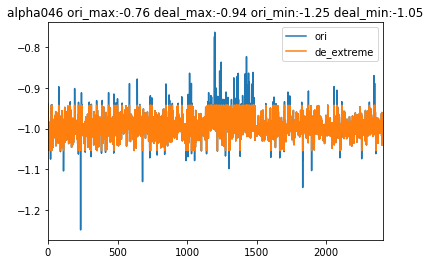

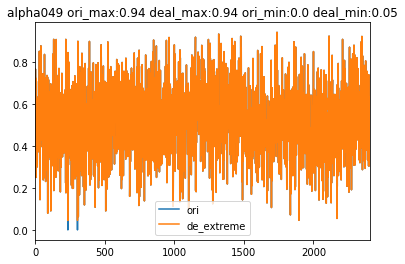

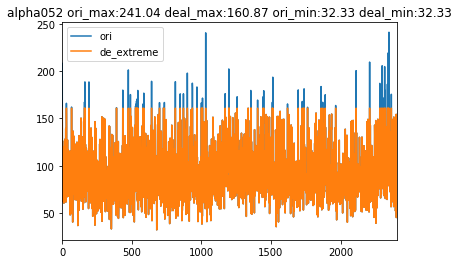

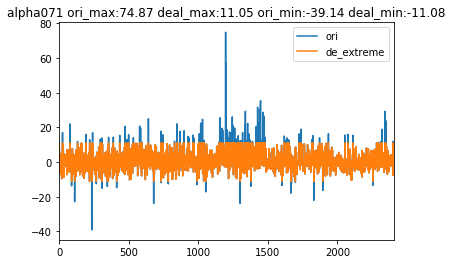

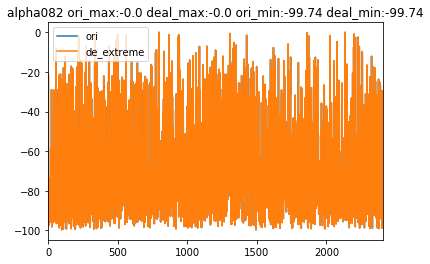

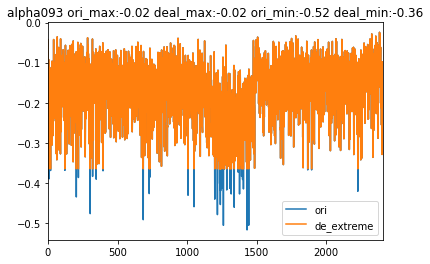

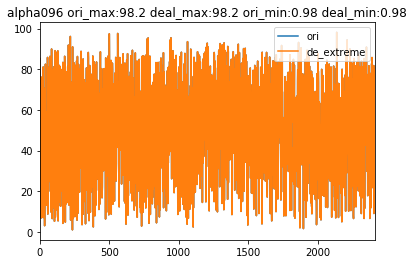

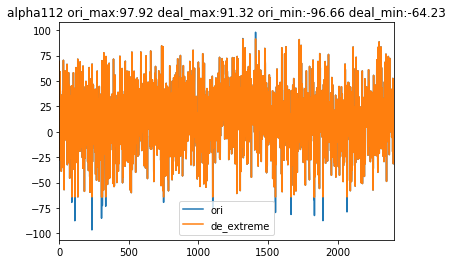

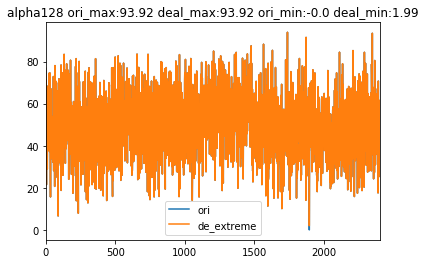

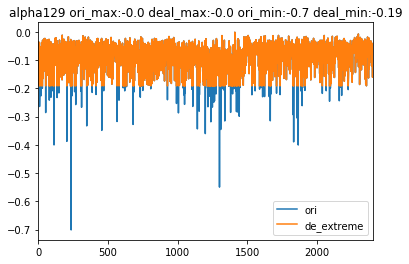

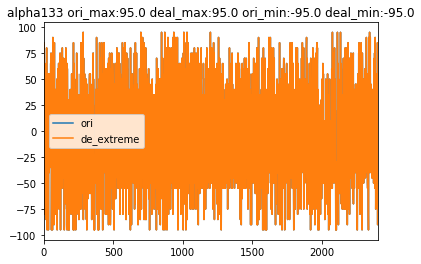

In [11]:
indicator_df_day_temp = de_extreme(indicator_df_day, feature_lst)

## 因子标准化

In [12]:
# 标准化函数：
def standardize(s, ty=1):
    '''
    s为Series数据
    ty为标准化类型:1 MinMax,2 Standard,3 maxabs
    '''
    data = s.dropna().copy()
    if int(ty) == 1:
        re = (data - data.min()) / (data.max() - data.min())
    elif ty == 2:
        re = (data - data.mean()) / data.std()
    elif ty == 3:
        re = data / 10 ** np.ceil(np.log10(data.abs().max()))
    return re

def standardize_df_noplot(indicator_df_day, ty=1):
    indicator_df_day_temp = copy.deepcopy(indicator_df_day)
    for alpha in feature_lst:
        ori = copy.deepcopy(indicator_df_day_temp[alpha])
        series = copy.deepcopy(ori)
        series = standardize(series, ty)
        indicator_df_day_temp[alpha] = copy.deepcopy(series)
    return(indicator_df_day_temp)

def standardize_df(indicator_df_day, ty=1):
    indicator_df_day_temp = copy.deepcopy(indicator_df_day)
    for alpha in feature_lst:
        ori = copy.deepcopy(indicator_df_day_temp[alpha])
        series = copy.deepcopy(ori)
        series = standardize(series, ty)
        indicator_df_day_temp[alpha] = copy.deepcopy(series)
        df = pd.DataFrame({'ori': ori, 'std': indicator_df_day_temp[alpha]})\
        .reset_index(drop=True)
#         plt.subplots(20, 10)
        df.loc[:, ['ori', 'std']].plot()
        plt.legend()
        plt.title('%s ori_max:%s deal_max:%s ori_min:%s deal_min:%s' %(
            alpha, np.around(ori.max(), 2), np.around(series.max(), 2), np.around(ori.min(), 2), 
                  np.around(series.min(), 2)))
        plt.show()
    return(indicator_df_day_temp)

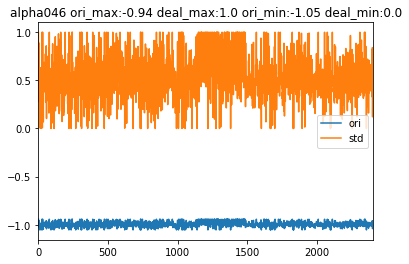

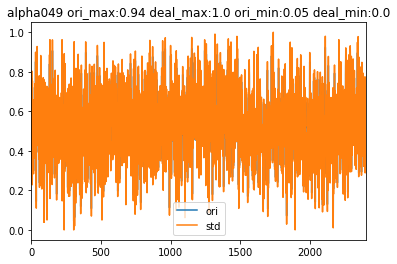

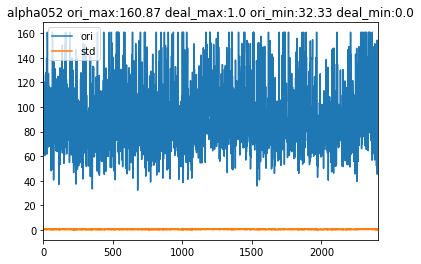

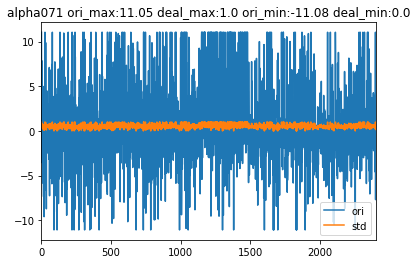

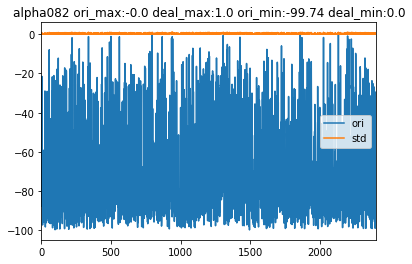

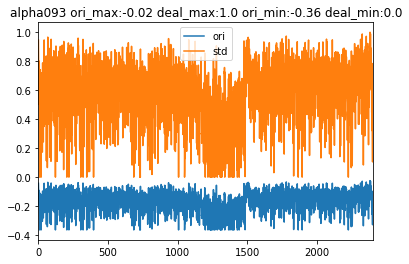

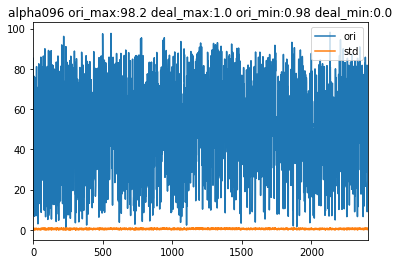

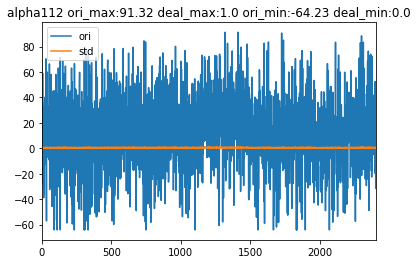

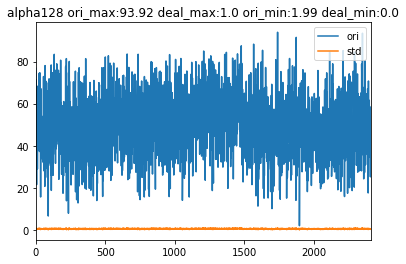

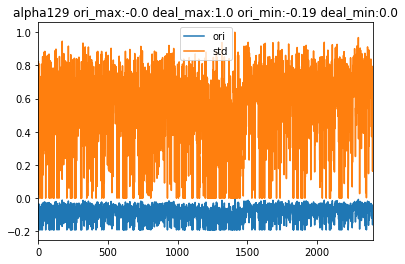

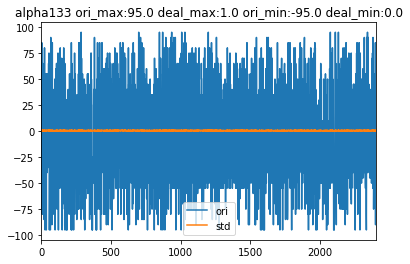

In [13]:
indicator_df_day_std = standardize_df(indicator_df_day_temp)

## 因子中性化（行业、市值）

In [19]:
# 中性化函数
# 传入：mkt_cap：以股票为index，市值为value的Series,
# factor：以股票code为index，因子值为value的Series,
# 输出：中性化后的因子值series
def neutralization(industry_index, industry_df, factor, date, mkt_cap=False, industry=True):
    y = factor
    if type(mkt_cap) == pd.Series:
        LnMktCap = mkt_cap.apply(lambda x: math.log(x))
        if industry:  # 行业、市值
            dummy_industry = get_industry_exposure(industry_df, industry_index, factor.index, date=date)
            x = pd.concat([LnMktCap, dummy_industry.T], axis=1)
        else:  # 仅市值
            x = LnMktCap
    elif industry:  # 仅行业
        dummy_industry = get_industry_exposure(industry_df, industry_index, factor.index, date=date)
        x = dummy_industry.T
    result = sm.OLS(y.astype(float), x.astype(float)).fit()
#     print(result)
    return result.resid


def get_industry_stocks_calen(industry_index, calen, stock_lst):
    industry_stocks_dict = []
    for i in range(0, len(industry_index)):
        for date in calen:
            print(date, industry_index[i])
            industry_stocks = get_industry_stocks(industry_index[i], date=date)
            for code in industry_stocks:
                industry_stocks_dict.append([date, code, industry_index[i]])
    df = pd.DataFrame(industry_stocks_dict, columns=['date_time', 'symbol', 'industry'])
    return(df)   


# 为股票池添加行业标记,return df格式 ,为中性化函数的子函数
def get_industry_exposure(industry_df, industry_index, stock_list, date):
    
    industry_df_ = industry_df[industry_df['date_time'] == date]
    industry_df_ = industry_df_.set_index(['symbol'])
    df = pd.DataFrame(index=industry_index, columns=stock_list)
    for stock in stock_list:
        try:
            idx = industry_df_[stock]
            df[stock][idx] = 1
        except:
            continue
    return df.fillna(0)  # 将NaN赋为0

def get_win_stand_neutra_noplot(industry_df, industry_index, indicator_std, feature_lst, date):
    stocks=list(indicator_std.index.values)
    h = get_fundamentals(query(valuation.code, valuation.market_cap) \
                         .filter(valuation.code.in_(stocks)), date=date)
    stocks_mktcap_se = pd.Series(list(h.market_cap), index=list(h.code))

    indicator_df_day_temp = copy.deepcopy(indicator_std)
    for alpha in feature_lst:
        ori = copy.deepcopy(indicator_df_day_temp[alpha])
        series = copy.deepcopy(ori)
        series = neutralization(industry_index, industry_df, series, date, stocks_mktcap_se)
#         print(series)
        indicator_df_day_temp[alpha] = copy.deepcopy(series)
    return(indicator_df_day_temp)


def get_win_stand_neutra(industry_df, industry_index, indicator_std, feature_lst, date):
    stocks=list(indicator_std.index.values)
    h = get_fundamentals(query(valuation.code, valuation.market_cap) \
                         .filter(valuation.code.in_(stocks)), date=date)
    stocks_mktcap_se = pd.Series(list(h.market_cap), index=list(h.code))

    indicator_df_day_temp = copy.deepcopy(indicator_std)
    for alpha in feature_lst:
        ori = copy.deepcopy(indicator_df_day_temp[alpha])
        series = copy.deepcopy(ori)
        series = neutralization(industry_index, industry_df, series, date, stocks_mktcap_se)
#         print(series)
        indicator_df_day_temp[alpha] = copy.deepcopy(series)
        df = pd.DataFrame({'ori': ori, 'neutra': indicator_df_day_temp[alpha]})\
        .reset_index(drop=True)
        df.loc[:, ['ori', 'neutra']].plot()
        plt.legend()
        plt.title('%s ori_max:%s deal_max:%s ori_min:%s deal_min:%s' %(
            alpha, np.around(ori.max(), 2), np.around(series.max(), 2), np.around(ori.min(), 2), 
                  np.around(series.min(), 2)))
        plt.show()
    return(indicator_df_day_temp)

In [20]:
calen = get_trade_days('2014-01-01', '2020-12-08')
industry_index = get_industries(name='sw_l1').index
try:
    industry_df = pd.read_csv('c:/e/data/factor/industry_stockcode.csv')
except Exception as e:
    industry_df = get_industry_stocks_calen(industry_index, calen, stock_lst)
    industry_df.to_csv('c:/e/data/factor/industry_stockcode.csv', index=False)

In [21]:
industry_df

,symbol,alpha046,alpha049,alpha052,alpha071,alpha082,alpha093,alpha096,alpha112,alpha128,alpha129,alpha133,date_time
0,000001.XSHE,-0.147065,0.051420,0.241476,-0.106227,0.128131,-0.276257,0.208231,-0.047456,-0.079149,-0.206787,0.224527,2015-01-05
1,000002.XSHE,0.126152,0.188901,0.253102,0.088353,0.222020,-0.188249,0.294290,0.142095,0.064642,-0.118914,-0.028775,2015-01-05
2,000004.XSHE,-0.011990,-0.074340,-0.238205,-0.078489,-0.051333,0.030851,-0.157435,-0.042040,0.226833,-0.068319,-0.054855,2015-01-05
3,000006.XSHE,0.166413,0.294485,0.178479,0.125621,0.481868,0.058128,0.445706,0.186741,0.235278,0.204012,0.287731,2015-01-05
4,000007.XSHE,0.226994,0.165337,-0.116177,0.135700,0.545527,-0.044902,0.339521,0.121787,0.096087,0.127440,-0.141477,2015-01-05
...,...,...,...,...,...,...,...,...,...,...,...,...,...
3245726,603167.XSHG,-0.159818,-0.210381,-0.089314,-0.219796,-0.090870,-0.297395,-0.161290,-0.196970,-0.224798,-0.202364,-0.325415,2020-10-29
3245727,603366.XSHG,0.076212,0.185425,0.120313,0.090136,-0.162998,0.279407,0.012253,0.176859,0.127502,0.235797,0.396297,2020-10-29
3245728,603399.XSHG,-0.130314,-0.020237,-0.209234,-0.135336,0.038256,-0.367031,-0.102993,-0.098719,-0.013289,0.139860,-0.307689,2020-10-29
3245729,603766.XSHG,0.236795,0.202818,0.059573,0.199158,-0.004891,0.059264,0.132189,0.245741,0.026842,0.221542,0.353311,2020-10-29


In [22]:
indicator_df_day_std

,alpha046,alpha049,alpha052,alpha071,alpha082,alpha093,alpha096,alpha112,alpha128,alpha129,alpha133
symbol,,,,,,,,,,,
000001.XSHE,1.000000,0.760329,1.000000,1.000000,0.783607,0.945328,0.867011,0.857407,0.813646,0.821967,0.710526
000002.XSHE,0.353966,0.363611,0.596551,0.392675,0.163766,0.806184,0.181152,0.283488,0.429650,0.660560,0.105263
000004.XSHE,0.890179,0.804309,0.731897,0.855777,0.784582,0.612440,0.698672,0.644202,0.754385,0.500100,0.947368
000005.XSHE,0.492119,0.496440,0.294355,0.435889,0.172823,0.569425,0.660496,0.535354,0.506644,0.671432,0.236842
000006.XSHE,0.278512,0.371965,0.597590,0.447149,0.120693,0.501656,0.106099,0.354957,0.570873,0.022999,0.842105
...,...,...,...,...,...,...,...,...,...,...,...
603333.XSHG,0.495538,0.521685,0.666402,0.525205,0.175655,0.784131,0.218504,0.447463,0.452017,0.688618,0.763158
603366.XSHG,0.537071,0.354108,0.422850,0.430566,0.116315,0.748911,0.242210,0.375952,0.379131,0.546454,0.263158
603399.XSHG,0.383424,0.423511,0.208326,0.179461,0.486453,0.298304,0.614002,0.356997,0.374251,0.375755,0.210526


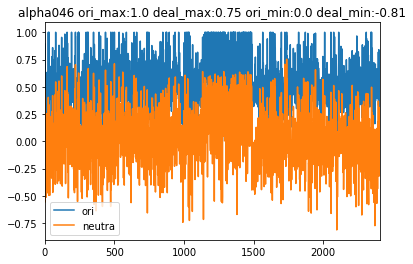

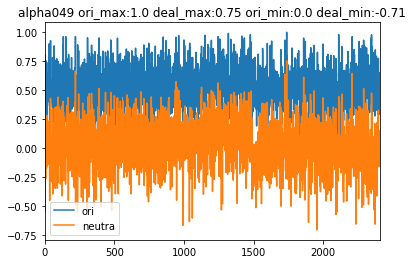

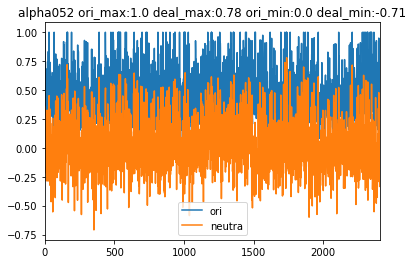

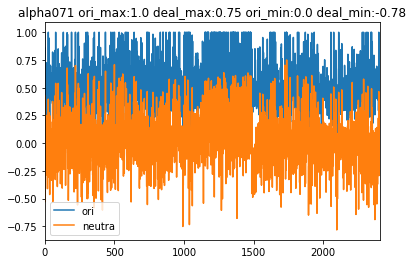

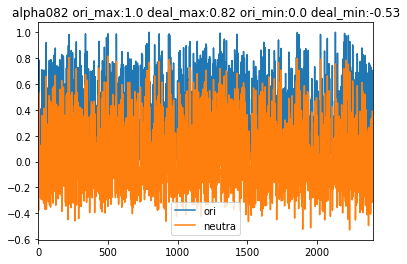

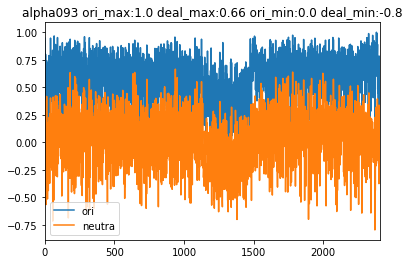

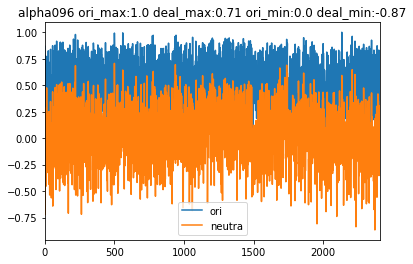

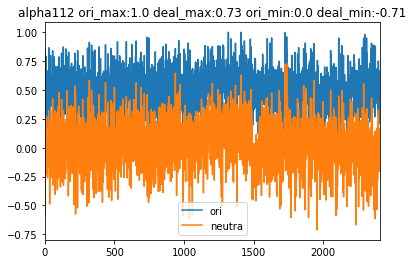

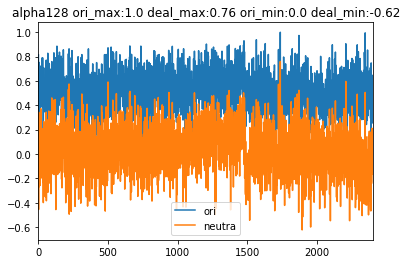

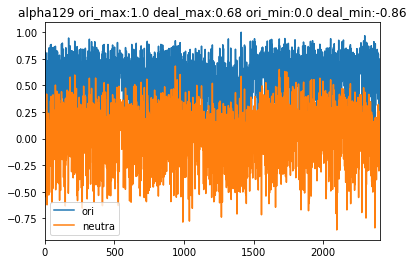

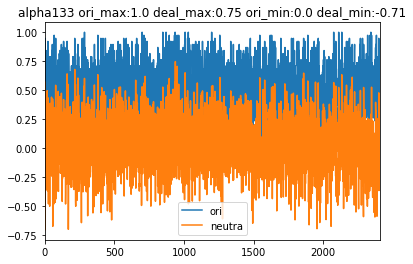

,alpha046,alpha049,alpha052,alpha071,alpha082,alpha093,alpha096,alpha112,alpha128,alpha129,alpha133
symbol,,,,,,,,,,,
000001.XSHE,0.080404,-0.158375,0.180589,0.070083,0.236596,-0.058012,-0.041760,-0.009773,-0.079281,-0.148590,-0.106593
000002.XSHE,-0.558386,-0.547855,-0.216405,-0.529916,-0.378935,-0.189251,-0.720460,-0.576860,-0.456243,-0.302350,-0.705419
000004.XSHE,0.466731,0.381271,0.354581,0.427576,0.532698,0.150429,0.280208,0.244889,0.343216,0.053185,0.571108
000005.XSHE,0.113430,0.118119,-0.043077,0.052951,-0.052435,0.156251,0.286266,0.178250,0.138937,0.271759,-0.099646
000006.XSHE,-0.221731,-0.127792,0.151847,-0.058707,-0.176871,-0.044142,-0.388255,-0.116772,0.085138,-0.504966,0.397608
...,...,...,...,...,...,...,...,...,...,...,...
603333.XSHG,0.086076,0.112620,0.301548,0.111147,-0.067908,0.337380,-0.186138,0.061340,0.054429,0.256465,0.399325
603366.XSHG,0.114867,-0.067686,0.046643,0.003624,-0.134828,0.288258,-0.175024,-0.022186,-0.030829,0.100853,-0.111997
603399.XSHG,-0.010158,0.030312,-0.142377,-0.218538,0.252336,-0.131120,0.225053,-0.014151,-0.007916,-0.039637,-0.139196


In [23]:
factor_deal=get_win_stand_neutra(industry_df, industry_index, indicator_df_day_std, feature_lst, '2020-10-20')
factor_deal

## 标准化处理后因子相关系数

In [24]:
factor_deal.corr()

,alpha046,alpha049,alpha052,alpha071,alpha082,alpha093,alpha096,alpha112,alpha128,alpha129,alpha133
alpha046,1.000000,0.833755,0.677555,0.946481,0.690477,0.348852,0.788419,0.858489,0.797464,0.443613,0.567854
alpha049,0.833755,1.000000,0.664520,0.870169,0.650616,0.449336,0.799338,0.940476,0.858267,0.558258,0.644952
alpha052,0.677555,0.664520,1.000000,0.762282,0.514029,0.264510,0.549692,0.621129,0.680616,0.200446,0.630578
alpha071,0.946481,0.870169,0.762282,1.000000,0.644257,0.365083,0.772706,0.873043,0.831508,0.403895,0.710250
alpha082,0.690477,0.650616,0.514029,0.644257,1.000000,0.298599,0.795712,0.631541,0.633433,0.352211,0.376520
alpha093,0.348852,0.449336,0.264510,0.365083,0.298599,1.000000,0.445756,0.456428,0.414340,0.726885,0.314633
alpha096,0.788419,0.799338,0.549692,0.772706,0.795712,0.445756,1.000000,0.807382,0.737098,0.527298,0.487263
alpha112,0.858489,0.940476,0.621129,0.873043,0.631541,0.456428,0.807382,1.000000,0.814250,0.642783,0.604181
alpha128,0.797464,0.858267,0.680616,0.831508,0.633433,0.414340,0.737098,0.814250,1.000000,0.404757,0.645744
alpha129,0.443613,0.558258,0.200446,0.403895,0.352211,0.726885,0.527298,0.642783,0.404757,1.000000,0.202496


## 对所有日期进行因子处理

In [25]:
indicator_ori = indicator_ori.dropna()
indicator_ori['future_ret'] = indicator_ori['future_ret'] - 1
indicator_df_ = indicator_ori.drop(['close', 'future_ret'], axis=1)
indicator_df_

,alpha046,alpha049,alpha052,alpha071,alpha082,alpha093,alpha096,alpha112,alpha128,alpha129,alpha133,date_time,symbol
26,-0.979478,0.670659,97.832370,3.505798,-19.726027,-0.104312,74.238965,15.151515,72.530892,-0.067714,20.0,2014-02-14,000001.XSHE
27,-0.991749,0.615385,105.167173,2.404335,-30.963470,-0.123120,73.820396,14.000000,66.292755,-0.069096,20.0,2014-02-17,000001.XSHE
28,-1.013776,0.585366,105.555556,-0.162602,-48.261905,-0.137006,62.861492,0.000000,59.082480,-0.091246,20.0,2014-02-18,000001.XSHE
29,-0.985595,0.652439,117.192429,2.694651,-77.408815,-0.137006,52.207002,27.118644,61.942514,-0.068445,20.0,2014-02-19,000001.XSHE
30,-1.004527,0.676471,116.018663,0.602695,-56.702128,-0.130513,50.159817,10.400000,68.356183,-0.089015,20.0,2014-02-20,000001.XSHE
...,...,...,...,...,...,...,...,...,...,...,...,...,...
1637,-1.001674,0.684211,89.159892,-0.074349,-54.000000,-0.133674,56.767677,34.693878,66.776400,-0.040867,-35.0,2020-10-23,603993.XSHG
1638,-1.008328,0.696429,80.839895,-0.691416,-67.395833,-0.146415,37.638889,34.693878,67.394872,-0.040520,-35.0,2020-10-26,603993.XSHG
1639,-0.995876,0.613636,89.779006,0.702875,-79.540441,-0.146415,29.030501,15.789474,67.491953,-0.040520,-30.0,2020-10-27,603993.XSHG
1640,-0.997641,0.552632,82.258065,0.565092,-47.352941,-0.124623,37.091503,-9.677419,75.596022,-0.043058,45.0,2020-10-28,603993.XSHG


In [26]:
try:
    indicator_deal = pd.read_csv('c:/e/data/factor/industry_stockcode.csv')
except:
    indicator_deal = []
    for date, group in indicator_df_.groupby(['date_time']):
        if date<'2015-01-01':
            continue
        print(date)
        try:
            indicator_deal.append(pd.read_csv('c:/e/data/factor/date/inicator_%s.csv' %date))
        except:

            group = group.drop(['date_time'], axis=1)
            group = group.set_index(['symbol'])
            indicator_df_day_de_extreme = de_extreme_noplot(group, feature_lst) # 去极值
            indicator_df_day_std = standardize_df_noplot(indicator_df_day_de_extreme) # 标准化
            factor_deal = get_win_stand_neutra_noplot(industry_df, industry_index, indicator_df_day_std, feature_lst, date)
            factor_deal = factor_deal.reset_index(drop=False)
            factor_deal['date_time'] = date
            factor_deal.to_csv('c:/e/data/factor/date/inicator_%s.csv' %date, index=False)
            indicator_deal.append(factor_deal)
    indicator_deal = pd.concat(indicator_deal) 
    print(indicator_deal)
    indicator_deal.to_csv('c:/e/data/factor/industry_stockcode.csv', index=False)

In [27]:
indicator_deal

,symbol,alpha046,alpha049,alpha052,alpha071,alpha082,alpha093,alpha096,alpha112,alpha128,alpha129,alpha133,date_time
0,000001.XSHE,-0.147065,0.051420,0.241476,-0.106227,0.128131,-0.276257,0.208231,-0.047456,-0.079149,-0.206787,0.224527,2015-01-05
1,000002.XSHE,0.126152,0.188901,0.253102,0.088353,0.222020,-0.188249,0.294290,0.142095,0.064642,-0.118914,-0.028775,2015-01-05
2,000004.XSHE,-0.011990,-0.074340,-0.238205,-0.078489,-0.051333,0.030851,-0.157435,-0.042040,0.226833,-0.068319,-0.054855,2015-01-05
3,000006.XSHE,0.166413,0.294485,0.178479,0.125621,0.481868,0.058128,0.445706,0.186741,0.235278,0.204012,0.287731,2015-01-05
4,000007.XSHE,0.226994,0.165337,-0.116177,0.135700,0.545527,-0.044902,0.339521,0.121787,0.096087,0.127440,-0.141477,2015-01-05
...,...,...,...,...,...,...,...,...,...,...,...,...,...
3245726,603167.XSHG,-0.159818,-0.210381,-0.089314,-0.219796,-0.090870,-0.297395,-0.161290,-0.196970,-0.224798,-0.202364,-0.325415,2020-10-29
3245727,603366.XSHG,0.076212,0.185425,0.120313,0.090136,-0.162998,0.279407,0.012253,0.176859,0.127502,0.235797,0.396297,2020-10-29
3245728,603399.XSHG,-0.130314,-0.020237,-0.209234,-0.135336,0.038256,-0.367031,-0.102993,-0.098719,-0.013289,0.139860,-0.307689,2020-10-29
3245729,603766.XSHG,0.236795,0.202818,0.059573,0.199158,-0.004891,0.059264,0.132189,0.245741,0.026842,0.221542,0.353311,2020-10-29


## 单因子检验 ICIR

In [28]:
# 计算IC值
def IC_cal(df, feature_lst):
    num = 0
    for i in feature_lst:
        t = df.loc[:, ['date_time', 'future_ret', i]].dropna()
        tmp = t.groupby('date_time').apply(lambda df: df.corr().iloc[0, 1]) \
            .reset_index().rename(columns={0: i})
        if num == 0:
            ret = tmp
        else:
            ret = pd.merge(ret, tmp, on=['date_time'], how='outer')
        num += 1
    return ret

# 计算rank_IC值
def rankIC_cal(df, feature_lst):
    num = 0
    for i in feature_lst:
        t = df.loc[:, ['date_time', 'future_ret', i]].dropna()
        t[i] = t[i].rank(ascending=False)
        tmp = t.groupby('date_time').apply(lambda df: df.corr().iloc[0, 1]) \
            .reset_index().rename(columns={0: i})
        if num == 0:
            ret = tmp
        else:
            ret = pd.merge(ret, tmp, on=['date_time'], how='outer')
        num += 1
    return ret

# 计算IR值
def IR_cal(df):
    IR = df.set_index('date_time').apply(lambda s: np.mean(s) / np.std(s))
    return IR

def IC_mean(df):
    return abs(df.mean())


def over_ratio(df, num):
    tmp = copy.deepcopy(df)
    tmp[tmp > num] = 1
    tmp[tmp <= num] = 0
    tmp = tmp.sum() / len(tmp)
    return tmp

In [29]:
indicator_df = indicator_deal.merge(indicator_ori[['date_time', 'symbol', 'future_ret']], on=['date_time', 'symbol'])

In [30]:
indicator_df

,symbol,alpha046,alpha049,alpha052,alpha071,alpha082,alpha093,alpha096,alpha112,alpha128,alpha129,alpha133,date_time,future_ret
0,000001.XSHE,-0.147065,0.051420,0.241476,-0.106227,0.128131,-0.276257,0.208231,-0.047456,-0.079149,-0.206787,0.224527,2015-01-05,-0.014620
1,000002.XSHE,0.126152,0.188901,0.253102,0.088353,0.222020,-0.188249,0.294290,0.142095,0.064642,-0.118914,-0.028775,2015-01-05,-0.036882
2,000004.XSHE,-0.011990,-0.074340,-0.238205,-0.078489,-0.051333,0.030851,-0.157435,-0.042040,0.226833,-0.068319,-0.054855,2015-01-05,0.049076
3,000006.XSHE,0.166413,0.294485,0.178479,0.125621,0.481868,0.058128,0.445706,0.186741,0.235278,0.204012,0.287731,2015-01-05,-0.032468
4,000007.XSHE,0.226994,0.165337,-0.116177,0.135700,0.545527,-0.044902,0.339521,0.121787,0.096087,0.127440,-0.141477,2015-01-05,-0.017562
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3245726,603167.XSHG,-0.159818,-0.210381,-0.089314,-0.219796,-0.090870,-0.297395,-0.161290,-0.196970,-0.224798,-0.202364,-0.325415,2020-10-29,-0.042008
3245727,603366.XSHG,0.076212,0.185425,0.120313,0.090136,-0.162998,0.279407,0.012253,0.176859,0.127502,0.235797,0.396297,2020-10-29,0.000000
3245728,603399.XSHG,-0.130314,-0.020237,-0.209234,-0.135336,0.038256,-0.367031,-0.102993,-0.098719,-0.013289,0.139860,-0.307689,2020-10-29,-0.047368
3245729,603766.XSHG,0.236795,0.202818,0.059573,0.199158,-0.004891,0.059264,0.132189,0.245741,0.026842,0.221542,0.353311,2020-10-29,-0.061728


In [18]:
del(indicator_deal)

In [31]:
# 计算 IC ，IR值
IC = IC_cal(indicator_df, feature_lst)
IR = IR_cal(IC)
IC

,date_time,alpha046,alpha049,alpha052,alpha071,alpha082,alpha093,alpha096,alpha112,alpha128,alpha129,alpha133
0,2015-01-05,-0.470352,-0.445465,-0.412650,-0.484187,-0.322181,-0.185915,-0.381237,-0.427422,-0.320989,-0.251755,-0.325783
1,2015-01-06,-0.032236,0.064384,0.085554,0.033223,0.068677,-0.018446,0.051083,0.013570,0.063330,-0.020395,0.069763
2,2015-01-07,-0.104825,-0.133144,-0.315716,-0.220799,0.179568,-0.028377,-0.037184,-0.137345,-0.136998,-0.054323,-0.207150
3,2015-01-08,-0.153884,-0.164718,-0.199185,-0.192695,-0.113007,-0.098148,-0.111327,-0.137936,-0.169398,-0.074512,-0.151634
4,2015-01-09,0.190210,0.064796,-0.118061,0.017538,0.117094,-0.127522,0.055442,0.078260,-0.043101,0.026099,-0.139403
...,...,...,...,...,...,...,...,...,...,...,...,...
1412,2020-10-23,0.104220,0.187620,0.176707,0.176774,0.054558,-0.016538,0.134840,0.181017,0.171491,-0.017952,0.175504
1413,2020-10-26,-0.121187,-0.099643,-0.020844,-0.077553,-0.139192,-0.070745,-0.094094,-0.096939,-0.050695,-0.097442,0.013653
1414,2020-10-27,0.032678,0.019544,0.045903,0.045594,0.080679,-0.051481,0.083769,0.028556,0.005505,-0.026121,0.073150
1415,2020-10-28,-0.016716,0.003024,0.020132,-0.014142,-0.017740,-0.037854,-0.017458,0.021386,-0.021799,-0.043742,0.014577


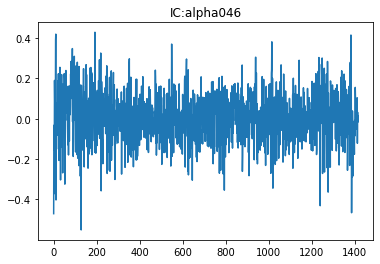

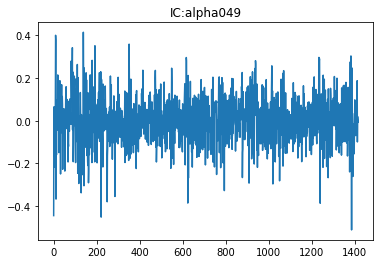

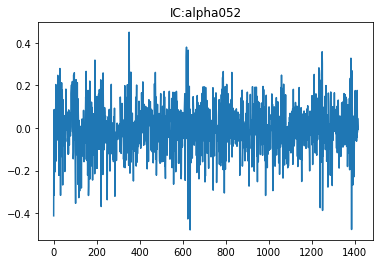

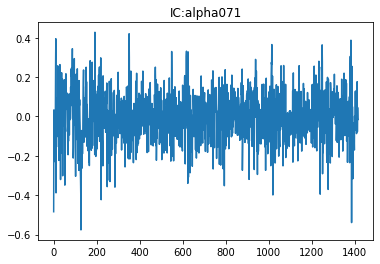

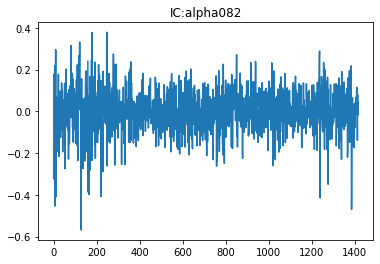

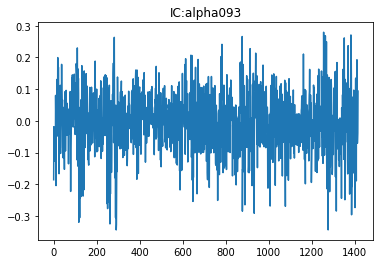

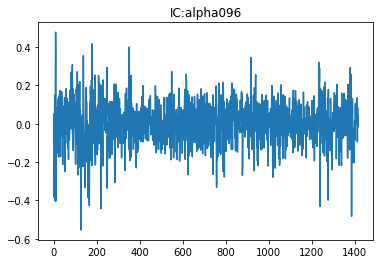

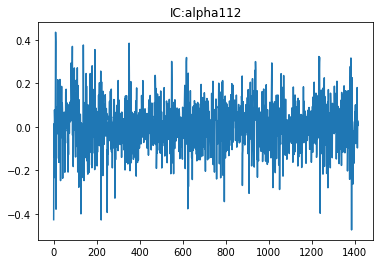

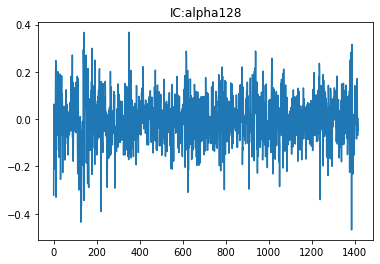

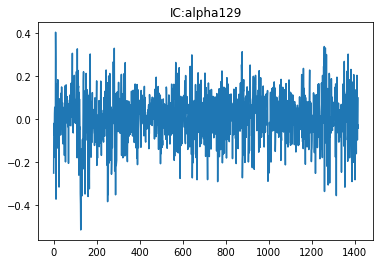

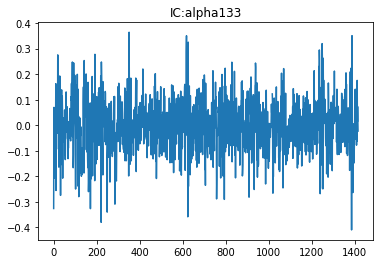

In [32]:
for factor in feature_lst:
    plt.plot(IC.loc[:, [factor]])
    plt.title('IC:%s' %factor)
    plt.show()

In [33]:
# 计算IC值大于某一阈值的比率
ic_mean = IC.iloc[:, 1:].mean()
ic_mean_df = pd.DataFrame(ic_mean, columns=['IC'])

In [34]:
ic_mean_df

,IC
alpha046,0.007810
alpha049,0.003035
alpha052,-0.004091
alpha071,-0.000099
alpha082,-0.000155
alpha093,-0.002544
alpha096,0.001575
alpha112,0.006088
alpha128,-0.003527
alpha129,0.006724


## IC值大于0比例

In [35]:
IC_over_ratio = over_ratio(IC.iloc[:, 1:], 0)
IC_over_ratio

alpha046    0.528582
alpha049    0.520819
alpha052    0.489061
alpha071    0.511644
alpha082    0.505999
alpha093    0.523641
alpha096    0.518701
alpha112    0.533522
alpha128    0.488356
alpha129    0.565984
alpha133    0.497530
dtype: float64

## ABS(IC)值大于0.02比例

In [36]:
IC_over2_ratio = over_ratio(abs(IC.iloc[:, 1:]), 0.02)
IC_over2_ratio

alpha046    0.852505
alpha049    0.848271
alpha052    0.852505
alpha071    0.879323
alpha082    0.828511
alpha093    0.808751
alpha096    0.849682
alpha112    0.868031
alpha128    0.836980
alpha129    0.846154
alpha133    0.829217
dtype: float64

In [37]:
IC

,date_time,alpha046,alpha049,alpha052,alpha071,alpha082,alpha093,alpha096,alpha112,alpha128,alpha129,alpha133
0,2015-01-05,-0.470352,-0.445465,-0.412650,-0.484187,-0.322181,-0.185915,-0.381237,-0.427422,-0.320989,-0.251755,-0.325783
1,2015-01-06,-0.032236,0.064384,0.085554,0.033223,0.068677,-0.018446,0.051083,0.013570,0.063330,-0.020395,0.069763
2,2015-01-07,-0.104825,-0.133144,-0.315716,-0.220799,0.179568,-0.028377,-0.037184,-0.137345,-0.136998,-0.054323,-0.207150
3,2015-01-08,-0.153884,-0.164718,-0.199185,-0.192695,-0.113007,-0.098148,-0.111327,-0.137936,-0.169398,-0.074512,-0.151634
4,2015-01-09,0.190210,0.064796,-0.118061,0.017538,0.117094,-0.127522,0.055442,0.078260,-0.043101,0.026099,-0.139403
...,...,...,...,...,...,...,...,...,...,...,...,...
1412,2020-10-23,0.104220,0.187620,0.176707,0.176774,0.054558,-0.016538,0.134840,0.181017,0.171491,-0.017952,0.175504
1413,2020-10-26,-0.121187,-0.099643,-0.020844,-0.077553,-0.139192,-0.070745,-0.094094,-0.096939,-0.050695,-0.097442,0.013653
1414,2020-10-27,0.032678,0.019544,0.045903,0.045594,0.080679,-0.051481,0.083769,0.028556,0.005505,-0.026121,0.073150
1415,2020-10-28,-0.016716,0.003024,0.020132,-0.014142,-0.017740,-0.037854,-0.017458,0.021386,-0.021799,-0.043742,0.014577


In [38]:
IR_df = pd.DataFrame(IR, columns=['IR'])
IR_df

,IR
alpha046,0.062061
alpha049,0.026984
alpha052,-0.035055
alpha071,-0.000768
alpha082,-0.001462
alpha093,-0.026985
alpha096,0.013990
alpha112,0.053591
alpha128,-0.034222
alpha129,0.058274


In [39]:
# # 计算 IC ，IR值,计算rankIC值大于某一阈值的比率
rankIC = rankIC_cal(indicator_df, feature_lst)
rankIR = IR_cal(rankIC)
rankic_mean = rankIC.iloc[:, 1:].mean()
rankic_mean_df = pd.DataFrame(rankic_mean, columns=['rankIC'])
rankic_mean_df

,rankIC
alpha046,-0.004396
alpha049,-0.002644
alpha052,0.003417
alpha071,0.000620
alpha082,-0.000094
alpha093,0.001644
alpha096,-0.001600
alpha112,-0.005021
alpha128,0.002517
alpha129,-0.004326


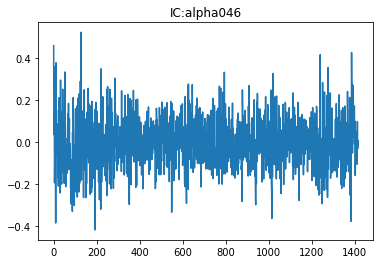

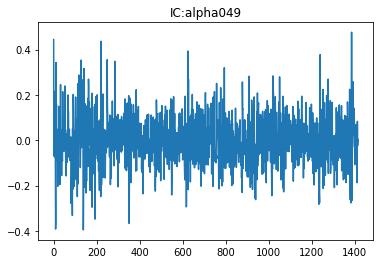

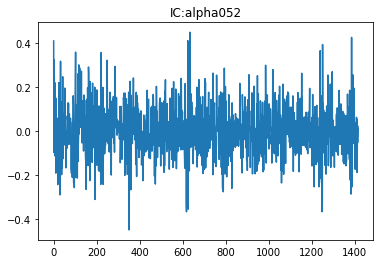

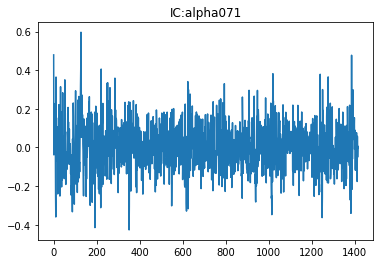

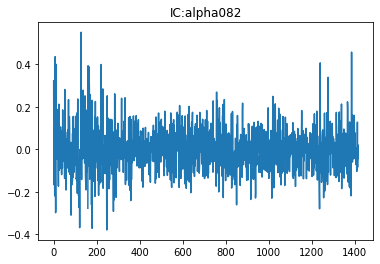

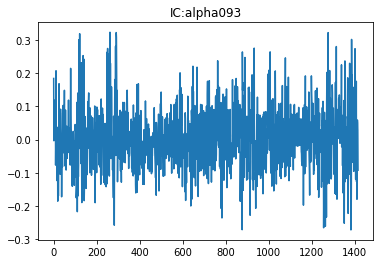

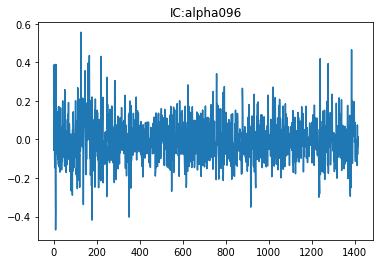

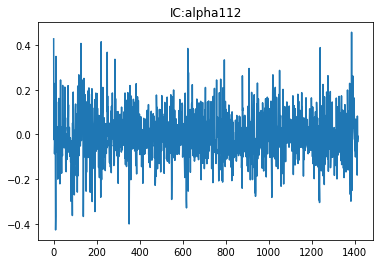

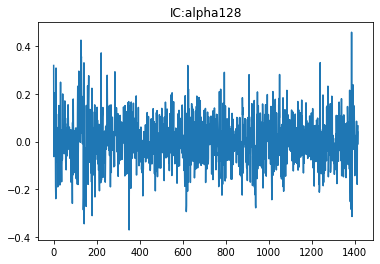

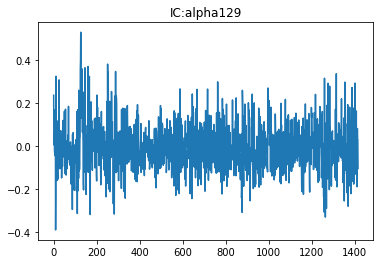

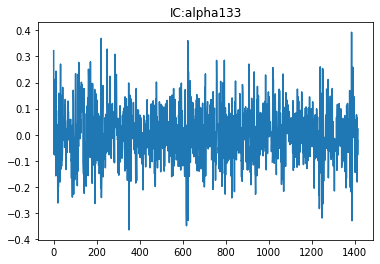

In [40]:
for factor in feature_lst:
    plt.plot(rankIC.loc[:, [factor]])
    plt.title('IC:%s' %factor)
    plt.show()

In [41]:
rankIR

alpha046   -0.036190
alpha049   -0.024005
alpha052    0.030247
alpha071    0.004963
alpha082   -0.000907
alpha093    0.018120
alpha096   -0.014380
alpha112   -0.044973
alpha128    0.025102
alpha129   -0.038737
alpha133    0.019642
dtype: float64

## 单因子回归模型

In [42]:
import statsmodels.api as sm
#模型训练
'''
调用模型的fit方法，对模型进行训练
这个训练过程就是参数求解的过程
并对模型进行拟合
'''
# #查看截距
# alpha = lrModel.intercept_[0]

def get_factor_return(x, y):
    x = sm.add_constant(x)
    model = sm.OLS(y, x, hasconst=True).fit()
#     print(model.summary())
    beta = model.params[1]
    tvalue = model.tvalues[1]
#     print('=========%s' % tvalue)
    return beta, tvalue

# 计算回归因子收益值
def f_cal(df, feature_lst):
    num = 0
    for i in feature_lst:
#         print(i)
        t = df.loc[:, ['date_time', 'future_ret', i]].dropna()
        tmp = t.groupby('date_time').apply(lambda df: get_factor_return(df.iloc[:, 2], df.iloc[:, 1])[0]) \
            .reset_index().rename(columns={0: i})
        if num == 0:
            ret = tmp
        else:
            ret = pd.merge(ret, tmp, on=['date_time'], how='outer')
        num += 1
    return ret


# 计算回归因子收益F的t值检验
def t_cal(df, feature_lst):
    num = 0
    for i in feature_lst:
#         print(i)
        t = df.loc[:, ['date_time', 'future_ret', i]].dropna()
        tmp = t.groupby('date_time').apply(lambda df: get_factor_return(df.iloc[:, 2], df.iloc[:, 1])[1]) \
            .reset_index().rename(columns={0: i})
        if num == 0:
            ret = tmp
        else:
            ret = pd.merge(ret, tmp, on=['date_time'], how='outer')
        num += 1
    return ret

In [43]:
F = f_cal(indicator_df, feature_lst)
F

,date_time,alpha046,alpha049,alpha052,alpha071,alpha082,alpha093,alpha096,alpha112,alpha128,alpha129,alpha133
0,2015-01-05,-0.079646,-0.072096,-0.059543,-0.084022,-0.040920,-0.028203,-0.047838,-0.074438,-0.058910,-0.037977,-0.034457
1,2015-01-06,-0.003910,0.008139,0.009190,0.004483,0.005962,-0.002041,0.005089,0.001830,0.008860,-0.002057,0.005841
2,2015-01-07,-0.014400,-0.020601,-0.041174,-0.033575,0.017263,-0.003542,-0.004228,-0.021914,-0.021967,-0.006508,-0.020676
3,2015-01-08,-0.013937,-0.018813,-0.020945,-0.021472,-0.008182,-0.008925,-0.008908,-0.015125,-0.019899,-0.006371,-0.011191
4,2015-01-09,0.028154,0.010461,-0.020290,0.003000,0.012036,-0.018870,0.007265,0.011584,-0.007667,0.002995,-0.018953
...,...,...,...,...,...,...,...,...,...,...,...,...
1412,2020-10-23,0.009891,0.020717,0.020197,0.017299,0.004789,-0.001543,0.011661,0.019248,0.020757,-0.001602,0.014792
1413,2020-10-26,-0.010924,-0.010382,-0.002158,-0.006985,-0.009390,-0.006411,-0.006690,-0.010002,-0.005691,-0.008345,0.000999
1414,2020-10-27,0.003107,0.002147,0.004924,0.004404,0.006338,-0.004948,0.006156,0.003264,0.000645,-0.002406,0.005507
1415,2020-10-28,-0.001609,0.000315,0.002216,-0.001364,-0.001456,-0.003550,-0.001316,0.002262,-0.002538,-0.003983,0.001053


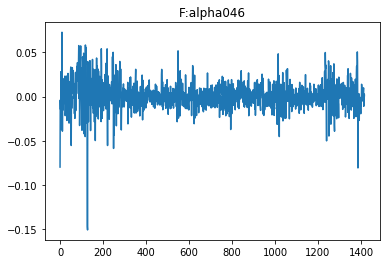

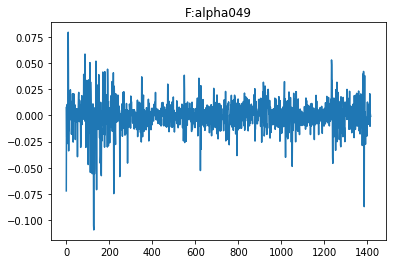

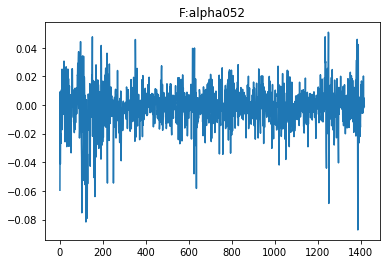

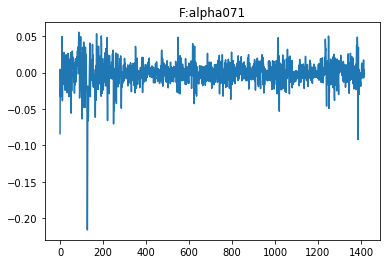

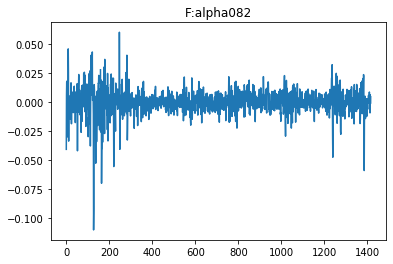

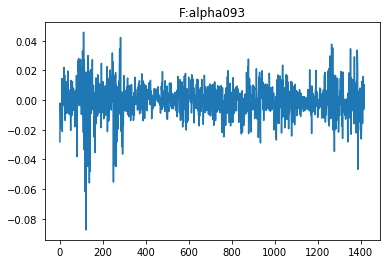

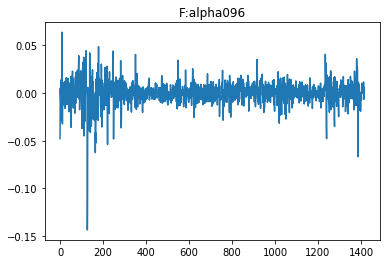

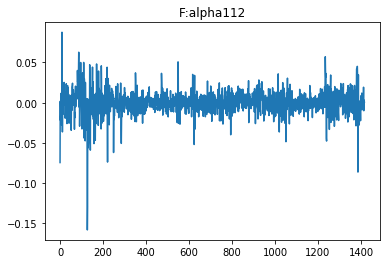

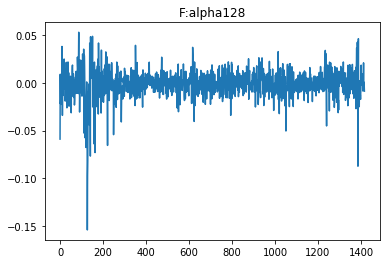

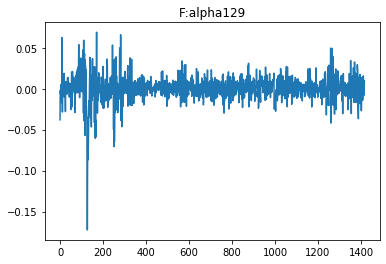

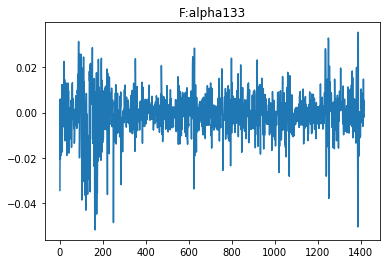

In [44]:
for factor in feature_lst:
    plt.plot(F.loc[:, [factor]])
    plt.title('F:%s' %factor)
    plt.show()

## 因子收益均值

In [45]:
F_mean = F.iloc[:, 1:].mean()
F_mean_df = pd.DataFrame(F_mean, columns=['F'])
F_mean_df

,F
alpha046,0.001410
alpha049,0.000110
alpha052,-0.000763
alpha071,-0.000046
alpha082,-0.000012
alpha093,-0.000059
alpha096,0.000068
alpha112,0.000561
alpha128,-0.000864
alpha129,0.000961


In [46]:
T_value = t_cal(indicator_df, feature_lst)
T_value

,date_time,alpha046,alpha049,alpha052,alpha071,alpha082,alpha093,alpha096,alpha112,alpha128,alpha129,alpha133
0,2015-01-05,-25.112821,-23.443447,-21.344823,-26.073465,-16.035184,-8.915144,-19.430093,-22.276159,-15.969028,-12.256690,-16.235596
1,2015-01-06,-1.519284,3.039176,4.044977,1.565883,3.242754,-0.869092,2.409467,0.639291,2.989228,-0.960943,3.294309
2,2015-01-07,-4.971984,-6.336818,-15.695022,-10.678616,8.610153,-1.339059,-1.755198,-6.540553,-6.523694,-2.566209,-9.987908
3,2015-01-08,-7.344541,-7.875548,-9.585525,-9.260930,-5.363697,-4.651036,-5.282925,-6.567749,-8.105860,-3.523736,-7.234596
4,2015-01-09,9.132877,3.060781,-5.604358,0.826830,5.557821,-6.060633,2.617470,3.700378,-2.033594,1.230675,-6.635968
...,...,...,...,...,...,...,...,...,...,...,...,...
1412,2020-10-23,5.139034,9.367390,8.804395,8.807829,2.679549,-0.811170,6.673623,9.026339,8.536514,-0.880501,8.742571
1413,2020-10-26,-5.988463,-4.912059,-1.022661,-3.815563,-6.894630,-3.478849,-4.635964,-4.777456,-2.489828,-4.802475,0.669755
1414,2020-10-27,1.603750,0.958846,2.253940,2.238767,3.970327,-2.528535,4.123427,1.401288,0.270037,-1.281699,3.597700
1415,2020-10-28,-0.819884,0.148305,0.987508,-0.693616,-0.870141,-1.857719,-0.856303,1.049032,-1.069302,-2.147216,0.714923


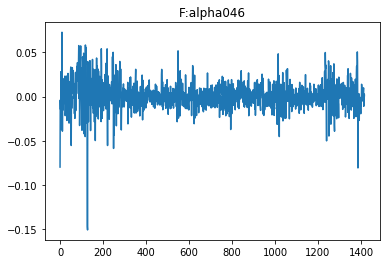

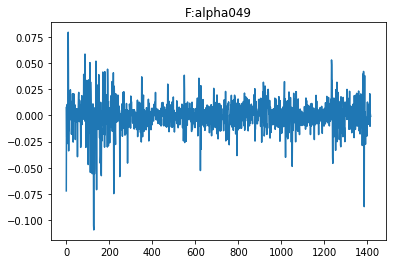

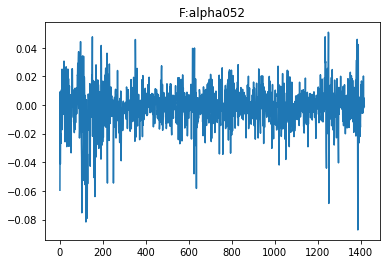

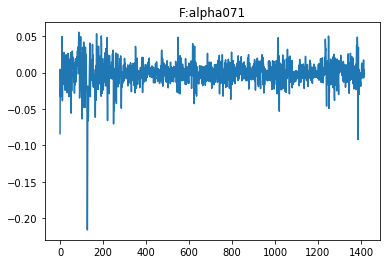

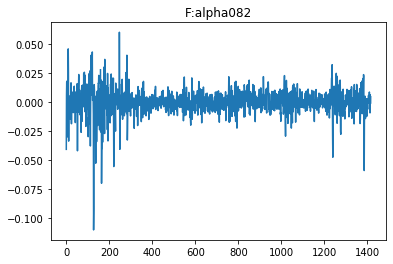

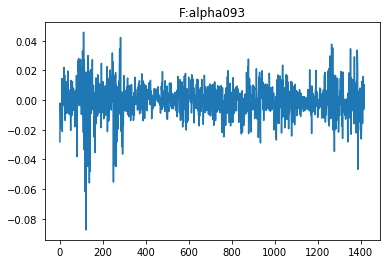

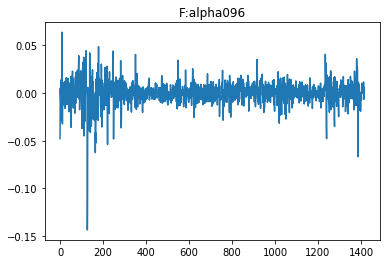

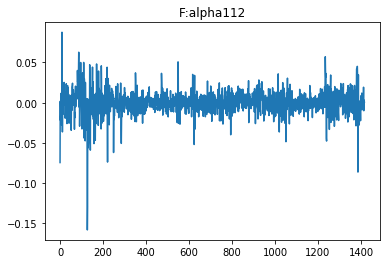

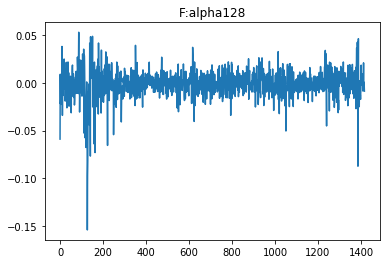

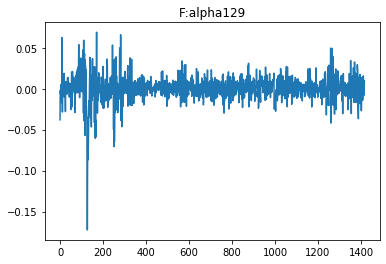

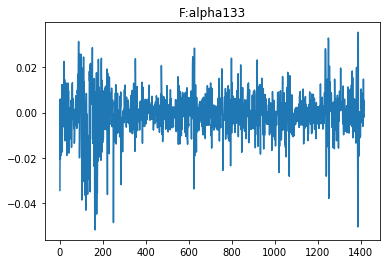

In [47]:
for factor in feature_lst:
    plt.plot(F.loc[:, [factor]])
    plt.title('F:%s' %factor)
    plt.show()

## T-value均值

In [48]:
Tvalue_mean = T_value.iloc[:, 1:].mean()
Tvalue_mean_df = pd.DataFrame(Tvalue_mean, columns=['Tvalue'])
Tvalue_mean_df

,Tvalue
alpha046,0.369822
alpha049,0.143616
alpha052,-0.197257
alpha071,-0.007251
alpha082,-0.015341
alpha093,-0.133291
alpha096,0.070145
alpha112,0.292291
alpha128,-0.166092
alpha129,0.335067


## T-value绝对值均值

In [49]:
Tvalue_abs_mean = abs(T_value.iloc[:, 1:]).mean()
Tvalue_abs_mean_df = pd.DataFrame(Tvalue_abs_mean, columns=['Tvalue'])
Tvalue_abs_mean_df

,Tvalue
alpha046,4.749880
alpha049,4.193869
alpha052,4.382363
alpha071,4.883918
alpha082,3.874852
alpha093,3.510041
alpha096,4.127736
alpha112,4.262674
alpha128,3.827600
alpha129,4.320977


In [50]:
T_value

,date_time,alpha046,alpha049,alpha052,alpha071,alpha082,alpha093,alpha096,alpha112,alpha128,alpha129,alpha133
0,2015-01-05,-25.112821,-23.443447,-21.344823,-26.073465,-16.035184,-8.915144,-19.430093,-22.276159,-15.969028,-12.256690,-16.235596
1,2015-01-06,-1.519284,3.039176,4.044977,1.565883,3.242754,-0.869092,2.409467,0.639291,2.989228,-0.960943,3.294309
2,2015-01-07,-4.971984,-6.336818,-15.695022,-10.678616,8.610153,-1.339059,-1.755198,-6.540553,-6.523694,-2.566209,-9.987908
3,2015-01-08,-7.344541,-7.875548,-9.585525,-9.260930,-5.363697,-4.651036,-5.282925,-6.567749,-8.105860,-3.523736,-7.234596
4,2015-01-09,9.132877,3.060781,-5.604358,0.826830,5.557821,-6.060633,2.617470,3.700378,-2.033594,1.230675,-6.635968
...,...,...,...,...,...,...,...,...,...,...,...,...
1412,2020-10-23,5.139034,9.367390,8.804395,8.807829,2.679549,-0.811170,6.673623,9.026339,8.536514,-0.880501,8.742571
1413,2020-10-26,-5.988463,-4.912059,-1.022661,-3.815563,-6.894630,-3.478849,-4.635964,-4.777456,-2.489828,-4.802475,0.669755
1414,2020-10-27,1.603750,0.958846,2.253940,2.238767,3.970327,-2.528535,4.123427,1.401288,0.270037,-1.281699,3.597700
1415,2020-10-28,-0.819884,0.148305,0.987508,-0.693616,-0.870141,-1.857719,-0.856303,1.049032,-1.069302,-2.147216,0.714923


## T-value>0比率

In [52]:
t_value_over_ratio = over_ratio(T_value.iloc[:, 1:], 0)
t_value_over_ratio

alpha046    0.528582
alpha049    0.520819
alpha052    0.489061
alpha071    0.511644
alpha082    0.505999
alpha093    0.523641
alpha096    0.518701
alpha112    0.533522
alpha128    0.488356
alpha129    0.565984
alpha133    0.497530
dtype: float64

In [81]:
T_value = t_cal(indicator_df, feature_lst)
T_value

,date_time,alpha046,alpha049,alpha052,alpha071,alpha082,alpha093,alpha096,alpha112,alpha128,alpha129,alpha133
0,2015-01-05,-25.112821,-23.443447,-21.344823,-26.073465,-16.035184,-8.915144,-19.430093,-22.276159,-15.969028,-12.256690,-16.235596
1,2015-01-06,-1.519284,3.039176,4.044977,1.565883,3.242754,-0.869092,2.409467,0.639291,2.989228,-0.960943,3.294309
2,2015-01-07,-4.971984,-6.336818,-15.695022,-10.678616,8.610153,-1.339059,-1.755198,-6.540553,-6.523694,-2.566209,-9.987908
3,2015-01-08,-7.344541,-7.875548,-9.585525,-9.260930,-5.363697,-4.651036,-5.282925,-6.567749,-8.105860,-3.523736,-7.234596
4,2015-01-09,9.132877,3.060781,-5.604358,0.826830,5.557821,-6.060633,2.617470,3.700378,-2.033594,1.230675,-6.635968
...,...,...,...,...,...,...,...,...,...,...,...,...
1412,2020-10-23,5.139034,9.367390,8.804395,8.807829,2.679549,-0.811170,6.673623,9.026339,8.536514,-0.880501,8.742571
1413,2020-10-26,-5.988463,-4.912059,-1.022661,-3.815563,-6.894630,-3.478849,-4.635964,-4.777456,-2.489828,-4.802475,0.669755
1414,2020-10-27,1.603750,0.958846,2.253940,2.238767,3.970327,-2.528535,4.123427,1.401288,0.270037,-1.281699,3.597700
1415,2020-10-28,-0.819884,0.148305,0.987508,-0.693616,-0.870141,-1.857719,-0.856303,1.049032,-1.069302,-2.147216,0.714923


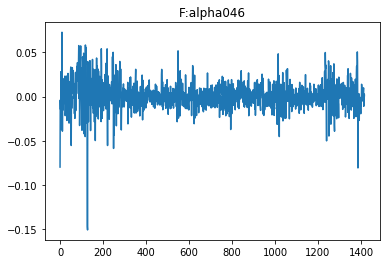

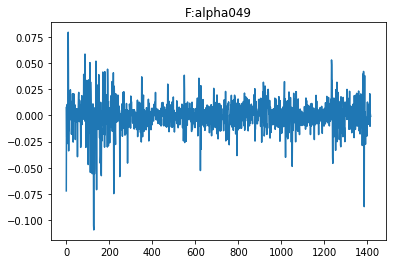

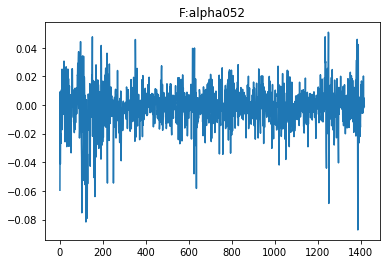

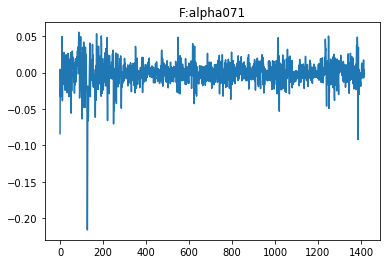

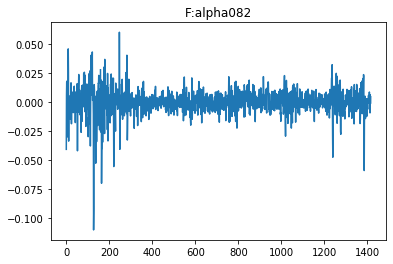

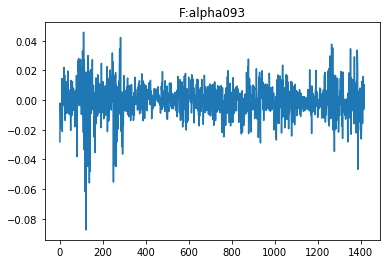

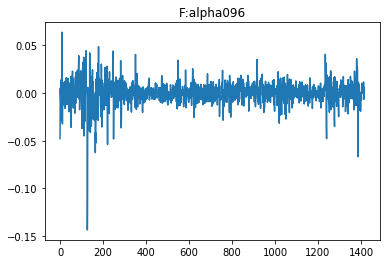

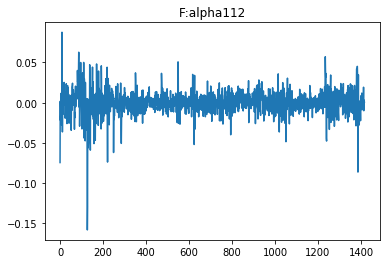

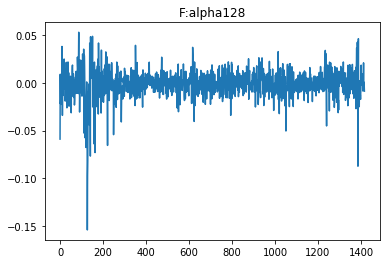

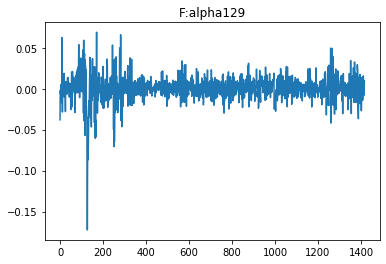

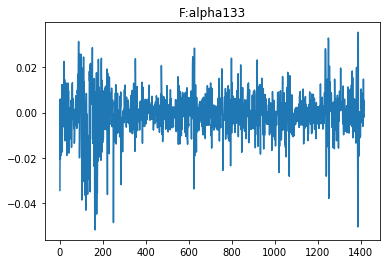

In [82]:
for factor in feature_lst:
    plt.plot(F.loc[:, [factor]])
    plt.title('F:%s' %factor)
    plt.show()

## T-value均值

In [90]:
Tvalue_mean = T_value.iloc[:, 1:].mean()
Tvalue_mean_df = pd.DataFrame(Tvalue_mean, columns=['Tvalue'])
Tvalue_mean_df

,Tvalue
alpha046,0.369822
alpha049,0.143616
alpha052,-0.197257
alpha071,-0.007251
alpha082,-0.015341
alpha093,-0.133291
alpha096,0.070145
alpha112,0.292291
alpha128,-0.166092
alpha129,0.335067


## T-value绝对值均值

In [91]:
Tvalue_abs_mean = abs(T_value.iloc[:, 1:]).mean()
Tvalue_abs_mean_df = pd.DataFrame(Tvalue_abs_mean, columns=['Tvalue'])
Tvalue_abs_mean_df

,Tvalue
alpha046,4.749880
alpha049,4.193869
alpha052,4.382363
alpha071,4.883918
alpha082,3.874852
alpha093,3.510041
alpha096,4.127736
alpha112,4.262674
alpha128,3.827600
alpha129,4.320977


In [92]:
T_value

,date_time,alpha046,alpha049,alpha052,alpha071,alpha082,alpha093,alpha096,alpha112,alpha128,alpha129,alpha133
0,2015-01-05,-25.112821,-23.443447,-21.344823,-26.073465,-16.035184,-8.915144,-19.430093,-22.276159,-15.969028,-12.256690,-16.235596
1,2015-01-06,-1.519284,3.039176,4.044977,1.565883,3.242754,-0.869092,2.409467,0.639291,2.989228,-0.960943,3.294309
2,2015-01-07,-4.971984,-6.336818,-15.695022,-10.678616,8.610153,-1.339059,-1.755198,-6.540553,-6.523694,-2.566209,-9.987908
3,2015-01-08,-7.344541,-7.875548,-9.585525,-9.260930,-5.363697,-4.651036,-5.282925,-6.567749,-8.105860,-3.523736,-7.234596
4,2015-01-09,9.132877,3.060781,-5.604358,0.826830,5.557821,-6.060633,2.617470,3.700378,-2.033594,1.230675,-6.635968
...,...,...,...,...,...,...,...,...,...,...,...,...
1412,2020-10-23,5.139034,9.367390,8.804395,8.807829,2.679549,-0.811170,6.673623,9.026339,8.536514,-0.880501,8.742571
1413,2020-10-26,-5.988463,-4.912059,-1.022661,-3.815563,-6.894630,-3.478849,-4.635964,-4.777456,-2.489828,-4.802475,0.669755
1414,2020-10-27,1.603750,0.958846,2.253940,2.238767,3.970327,-2.528535,4.123427,1.401288,0.270037,-1.281699,3.597700
1415,2020-10-28,-0.819884,0.148305,0.987508,-0.693616,-0.870141,-1.857719,-0.856303,1.049032,-1.069302,-2.147216,0.714923


## T-value>0比率

In [56]:
t_value_over_ratio = over_ratio(T_value.iloc[:, 1:], 0)
t_value_over_ratio

alpha046    0.528582
alpha049    0.520819
alpha052    0.489061
alpha071    0.511644
alpha082    0.505999
alpha093    0.523641
alpha096    0.518701
alpha112    0.533522
alpha128    0.488356
alpha129    0.565984
alpha133    0.497530
dtype: float64

## abs(T-value)>0.02比率

In [57]:
t_abs_value_over_ratio = over_ratio(abs(T_value.iloc[:, 1:]), 0.02)
t_abs_value_over_ratio

alpha046    0.998589
alpha049    0.997177
alpha052    0.997883
alpha071    0.997883
alpha082    0.994354
alpha093    0.994354
alpha096    0.997883
alpha112    0.997177
alpha128    0.995766
alpha129    0.995766
alpha133    0.995766
dtype: float64